Code modified from:

https://github.com/codingforentrepreneurs/OpenCV-Python-Series/blob/master/src/camera-test.py

Video capture settings described on:

https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-set


In [1]:
import numpy as np
import cv2
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
#### Simple threshold requirement:
#  At least Nthr pixels with value Athr counts above  Mthr times maximum-mean from mean

Nthr = 3    # number of pixels required above threshold

Athr = 10    # threshold in pixels
Mthr =  4    # threshold in maximum-mean distance for given pixel

# Averaging period for maximum and mean calculation

Nmax = 100

In [3]:
# Open device

mycam = 7    # Device number for second external WebCam
# mycam = 0    # Build-in webcam

cap = cv2.VideoCapture(mycam) 

if not cap.isOpened() :
    print(f"Could not open video device {mycam}")
else :
    print(f"Streaming from device {mycam}")

print("Default resolution: ",cap.get(cv2.CAP_PROP_FRAME_WIDTH)," x ",
                             cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# print("Default frame rate: ",cap.get(cv2.CAP_PROP_FPS))
# print("Default gain: ",cap.get(cv2.CAP_PROP_GAIN))

# Modify image size

# imgsz = (640, 480)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, imgsz[0])
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, imgsz[1])

# Modify frame rate 

# imgrate = 30
# cap.set(cv2.CAP_PROP_FPS, imgrate)

# Running average, maximum

Vmax = 0.
Vmean = 0.

# Main loop    

Nframe = 0
t_start = datetime.now()
print(f"Data taking started at {t_start}  ({t_start.timestamp():.3f})")

# History of maximum counts

Nhist = 0
Hist_list = []
Max_list = []
Mean_list = []

# History of events

Nevt = 0

Tevt_list = []
Nevt_list = []
Sig_list = []
Val_list = []

frac = 1.0/Nmax
frac1 = 1.0 - frac

while(cap.isOpened()):

    # Debug output for threshold level
    
    if Nframe > 0 and Nframe%Nmax == 0 :
        print("Average pixel after {:d} frames: {:.2f} +/- {:.2f}  Max:  {:.2f} +/- {:.2f}".format(Nframe,np.mean(Vmean),np.std(Vmean),np.mean(Vmax),np.std(Vmax)),end="\r")

        Hist_list.append(t_frame)
        Max_list.append(np.mean(Vmax))
        Mean_list.append(np.mean(Vmean))
        Nhist+=1

    # Desplay flat frame after the initialization stage
    
    if Nframe == Nmax:
        fmean = Vmean.astype(np.uint8)
        cv2.imshow('WebCam',fmean)
        cv2.setWindowTitle('WebCam','WebCam mean frame')
    
    # Capture video stream frame-by-frame
    
    ret, frame = cap.read()

    if ret == True:

        t_frame = (datetime.now() - t_start).total_seconds()   # frame time from start of data taking [s]

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    # output is 2D array
        
        if Nframe == 0 :             # Frist frame
            Vmax  = np.zeros_like(gray, dtype=np.float64)
            Vmean = np.zeros_like(gray, dtype=np.float64)
            
        if Nframe < Nmax :           # First Nmax frames - calibration
            Vmax   = np.maximum(Vmax,gray)
            Vmean += frac * gray

        else :         # After calibration, taking data
            
            # Threshold level for this frame (with mean frame as reference)
            
            Vthr = Mthr*(Vmax-Vmean) + Athr  

            # Significance: frame ratio to threshold frame (distance from mean)
            
            sigframe = (gray - Vmean)/Vthr

            # Find pixels with highest significance  (above the threshold)
            
            fsort = np.argsort(sigframe.flatten())
            gsort = gray.flatten()[fsort]
            ssort = sigframe.flatten()[fsort]

            nsort=fsort.size
                        
            # Lowest of the required signal pixels

            ithr = nsort - Nthr
    
            # Required number of frame pixels found above threshold (with significance > 1)
            
            if ssort[ithr] > 1.0 :    
                
                Tevt_list.append(t_frame)
                Nevt_list.append(Nframe)
                Val_list.append(gsort[ithr])
                Sig_list.append(ssort[ithr])
                Nevt+=1

                # flat corrected frame
                
                fcorr = np.maximum(gray - Vmean + np.mean(Vmean), 0.).astype(np.uint8)
                
                outname = 'cam_'+str(mycam)+'_frame_'+str(Nframe)+'.png'
                cv2.imwrite(outname,frame,[cv2.IMWRITE_PNG_COMPRESSION, 3])   # Default is 16 - poor quality !

                outname = 'cam_'+str(mycam)+'_frame_'+str(Nframe)+'_corr.png'
                cv2.imwrite(outname,fcorr,[cv2.IMWRITE_PNG_COMPRESSION, 3])

                xmax = fsort[-1]%frame.shape[1]
                ymax = fsort[-1]//frame.shape[1]
        
                cv2.drawMarker(frame,(xmax,ymax),(200,200,255),cv2.MARKER_SQUARE,20,1)     # Light red square. Color is (B,G,R) !
                
                cv2.imshow('WebCam',frame)
        
                cv2.setWindowTitle('WebCam','WebCam event #'+str(Nframe)+' maximum at '+str(xmax)+':'+str(ymax))
        
                print("\nFrame # ",Nframe," : ",gsort[ithr:]," at (",xmax,",",ymax,")  S = ",ssort[ithr:])

            
            # Add to sum (also if event detected !)
            
            Vmax  = np.maximum(frac1*Vmax+frac*Vmean,gray)
            Vmean = frac1*Vmean  + frac*gray
         
        
        Nframe += 1

    # Could not read frame
    
    else:
        break
        
    if cv2.waitKey(20) & 0xFF  ==  ord('q'):   # Break if 'q' pressed on display window
        break


# Loop completed

t_end = datetime.now()

tcap = (t_end-t_start).total_seconds()
frate = Nframe/tcap

print(f"{Nframe} frames captured in {tcap} s")
print(f"Average rate {frate} Hz")

# When everything done, release the capture

cap.release()
cv2.destroyAllWindows()

[ WARN:0@1.231] global cap_gstreamer.cpp:1777 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


Streaming from device 5
Default resolution:  640.0  x  480.0
Data taking started at 2025-02-28 14:23:42.432017  (1740749022.432)
Average pixel after 500 frames: 110.81 +/- 1.93  Max:  113.68 +/- 4.09
Frame #  546  :  [144 135 144]  at ( 617 , 166 )  S =  [1.06763962 1.09310918 1.11536255]
Average pixel after 2700 frames: 110.78 +/- 2.08  Max:  113.27 +/- 4.35
Frame #  2769  :  [140 136 141]  at ( 12 , 58 )  S =  [1.03111909 1.11852915 1.19547943]
Average pixel after 3100 frames: 110.81 +/- 2.12  Max:  113.44 +/- 4.45
Frame #  3142  :  [158 180 186]  at ( 140 , 413 )  S =  [3.71528573 5.73307742 6.18588711]

Frame #  3160  :  [151 137 134]  at ( 52 , 433 )  S =  [1.21469972 1.40737675 1.42528154]
Average pixel after 3300 frames: 110.81 +/- 2.13  Max:  113.40 +/- 4.45
Frame #  3332  :  [178 181 181]  at ( 91 , 263 )  S =  [5.73265988 6.71046745 6.77912301]
Average pixel after 3400 frames: 110.81 +/- 2.14  Max:  113.43 +/- 4.47
Frame #  3425  :  [163 157 157]  at ( 162 , 178 )  S =  [3.41

In [7]:
tevt = tcap/Nevt

print(f"{Nevt} events found in {tcap} s")
print(f"Average time between events is {tevt} s")

136 events found in 1406.059812 s
Average time between events is 10.338675088235293 s


In [8]:
Ntab = np.arange(Nmax,Nframe,Nmax)
Ttab = np.array(Hist_list)
Mtab = np.array(Mean_list)
Xtab = np.array(Max_list)

Ntrg = np.array(Nevt_list)
Ttrg = np.array(Tevt_list)
Vtrg = np.array(Val_list)
Strg = np.array(Sig_list)

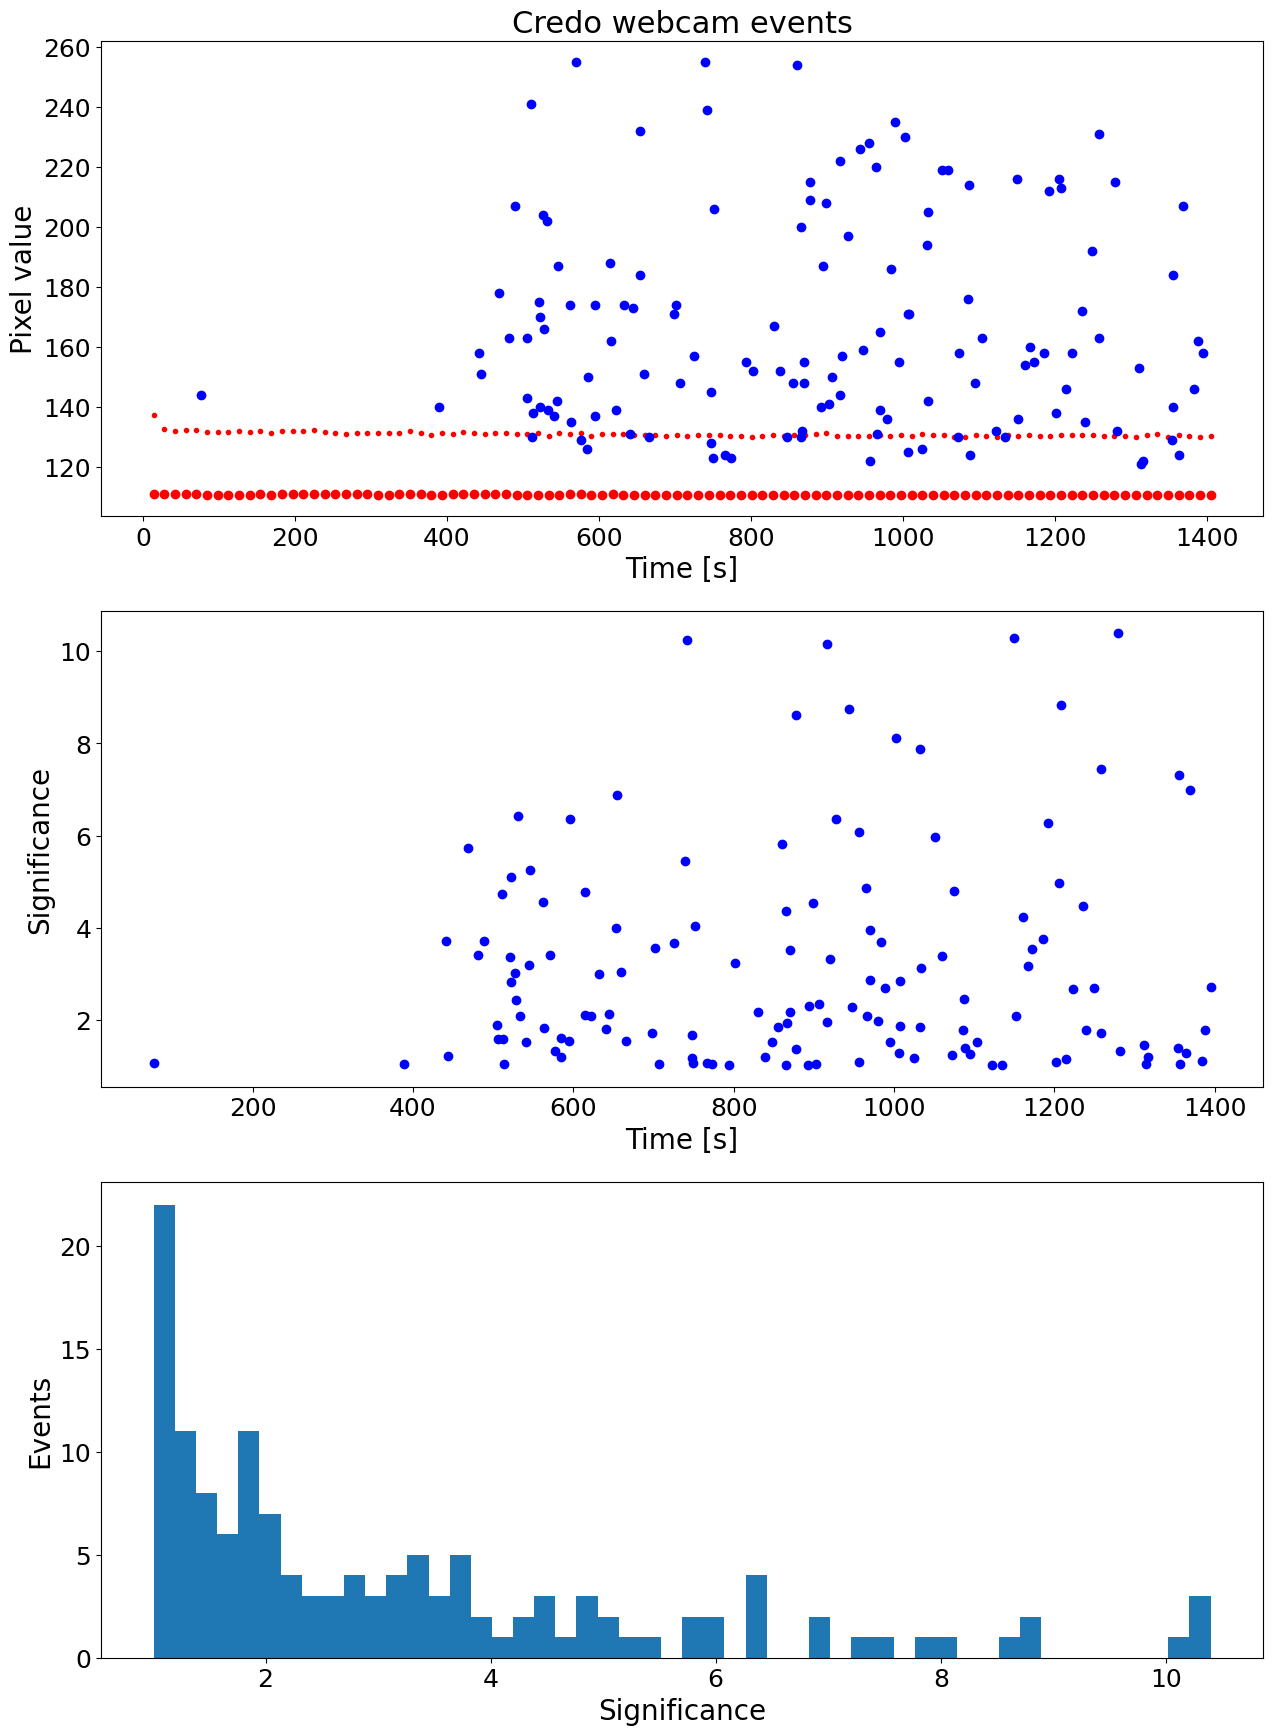

In [12]:
# Plot image distributions

plt.subplots(3,1,figsize=(15, 21))

plt.subplot(311)

if Nhist < 100 :
    plt.plot(Ttab,Mtab,'r-')
    plt.plot(Ttab,Mtab+Mthr*(Xtab-Mtab)+Athr,'r--')
else :
    plt.plot(Ttab,Mtab,'ro')
    plt.plot(Ttab,Mtab+Mthr*(Xtab-Mtab)+Athr,'r.')


plt.plot(Ttrg,Vtrg,'bo')

plt.xlabel('Time [s]',size=20)
plt.ylabel('Pixel value',size=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Credo webcam events",fontsize=22)


plt.subplot(312)

plt.plot(Ttrg,Strg,'bo')

plt.xlabel('Time [s]',size=20)
plt.ylabel('Significance',size=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(313)

plt.hist(Strg,bins=50)

plt.ylabel('Events',size=20)
plt.xlabel('Significance',size=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fname = 'cosmic-trigger.png'

plt.savefig(fname)

plt.show()